# 06 - Restart Evolution Strategy [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/06_restart_es.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX on NVIDIA GPU with:

In [ ]:
%pip install -U "jax[cuda]"

Then, install `evosax` from PyPi:

In [ ]:
%pip install -U "evosax[examples]"

## Import

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax

In [2]:
seed = 0
key = jax.random.key(seed)

## IPOP-OpenAI-ES

### CartPole environment

In [43]:
from evosax.problems import GymnaxProblem as Problem
from evosax.problems.networks import MLP, categorical_output_fn

policy = MLP(
    layer_sizes=(64, 64, 2),
    output_fn=categorical_output_fn,
)

problem = Problem(
    env_name="CartPole-v1",
    policy=policy,
    episode_length=200,
    num_rollouts=16,
    use_normalize_obs=True,
)

key, subkey = jax.random.split(key)
problem_state = problem.init(key)

key, subkey = jax.random.split(key)
solution = problem.sample(subkey)

In [44]:
print(f"Number of pararmeters: {sum(leaf.size for leaf in jax.tree.leaves(solution))}")

Number of pararmeters: 4610


### OpenAI-ES

In [48]:
from evosax.algorithms import Open_ES as ES

es = ES(
    population_size=16,
    solution=solution,
    optimizer=optax.adam(learning_rate=0.01),
    std_schedule=optax.constant_schedule(0.1),
)

params = es.default_params

### Restart OpenAI-ES on CartPole when fitness converges and double Population Size Each Time!

In [52]:
def fitness_std_cond(population, fitness, state, params):
    return jnp.std(fitness) < 0.001

### Run

In [ ]:
num_generations = 64

key, subkey = jax.random.split(key)
state = es.init(subkey, solution, params)

metrics_log = []
restart_generations = []
for i in range(num_generations):
    key, subkey = jax.random.split(key)
    key_ask, key_eval, key_tell = jax.random.split(subkey, 3)

    population, state = es.ask(key_ask, state, params)
    fitness, problem_state, info = problem.eval(key_eval, population, problem_state)
    state, metrics = es.tell(key_tell, population, -fitness, state, params)

    if fitness_std_cond(population, fitness, state, params):
        mean = es.get_mean(state)

        key, subkey = jax.random.split(key)
        state = es.init(subkey, mean, params)

        restart_generations.append(i)

    # Log metrics
    metrics_log.append(metrics)

In [ ]:
print(f"Number of pararmeters: {sum(leaf.size for leaf in jax.tree.leaves(solution))}")

Number of pararmeters: 4610


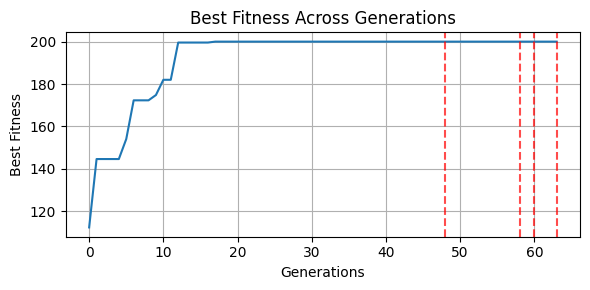

In [59]:
# Extract best fitness values from metrics_log
generations = list(range(len(metrics_log)))
best_fitness = [-metrics["best_fitness"] for metrics in metrics_log]

# Create the plot
plt.figure(figsize=(6, 3))
plt.plot(generations, best_fitness)

# Add vertical lines for restart generations
for gen in restart_generations:
    plt.axvline(x=gen, color="r", linestyle="--", alpha=0.7)

plt.xlabel("Generations")
plt.ylabel("Best Fitness")
plt.title("Best Fitness Across Generations")
plt.grid(True)
plt.tight_layout()
plt.show()

## BIPOP-CMA-ES

### CMA-ES

In [60]:
from evosax.algorithms import CMA_ES as ES

es = ES(
    population_size=16,
    solution=solution,
)

params = es.default_params

### Run

In [ ]:
from evosax.restarts.restart_conds import cma_cond, spread_cond

num_generations = 512

key, subkey = jax.random.split(key)
state = es.init(subkey, solution, params)

metrics_log = []
restart_generations = []
for i in range(num_generations):
    key, subkey = jax.random.split(key)
    key_ask, key_eval, key_tell = jax.random.split(subkey, 3)

    population, state = es.ask(key_ask, state, params)
    fitness, problem_state, info = problem.eval(key_eval, population, problem_state)
    state, metrics = es.tell(key_tell, population, -fitness, state, params)

    if spread_cond(population, fitness, state, params) | cma_cond(
        population, fitness, state, params
    ):
        mean = es.get_mean(state)

        key, subkey = jax.random.split(key)
        state = es.init(subkey, mean, params)

        restart_generations.append(i)

    # Log metrics
    metrics_log.append(metrics)